In [1]:
!pip install pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import nltk
import re
import string


In [3]:
# Import data from dataset from Kaggle
all_data = pd.read_csv("netflix_titles.csv")

In [4]:
# Clean data to only include show ID, title, type, list_in, director, cast, and description.
all_data = all_data[["show_id", "title", "type", "listed_in", "director", "cast","description"]]

In [5]:
# Show data.
#all_data.head()

In [6]:
# Stopwords will get rid of unwanted words.
nltk.download('stopwords')
from nltk.corpus import stopwords
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Cleaning data

#Replace all null values to Unknown.I do not want to remove any movies. 
all_data = all_data.replace(to_replace=np.nan,value='Unknown')

# Remove spaces between words in genre column. 
all_data['listed_in'] = all_data['listed_in'].str.replace(' ','')

# Remove '-' between words in genre column. For sci-fi -> scifi
all_data['listed_in'] = all_data['listed_in'].str.replace('-','')

# Remove 's' in show_id
all_data['show_id'] = all_data['show_id'].str.replace('s','')

# Change type in column show_id to integer
all_data['show_id'] = all_data['show_id'].astype('int')

# Convert all letters it title to lower case
all_data['title'] = all_data['title'].str.lower()

In [8]:
#all_data.head()

In [9]:
# Making table that just includes genre.
simple_data = all_data[["show_id", "title", "type", "listed_in"]]

In [10]:
#simple_data.head()

In [11]:
# Create dataframe to include Show ID, Title, and Type.
type_df = simple_data[["show_id", "title", "type"]]
#display(type_df)

In [12]:
# Get total number of movies and total number of shows
type_counts = type_df['type'].value_counts()
#display(type_counts)

In [13]:
# Convert 'type_count' series to dataframe
type_counts_df = type_counts.to_frame('count').reset_index()
#display(type_counts_df)

Text(0, 0.5, '')

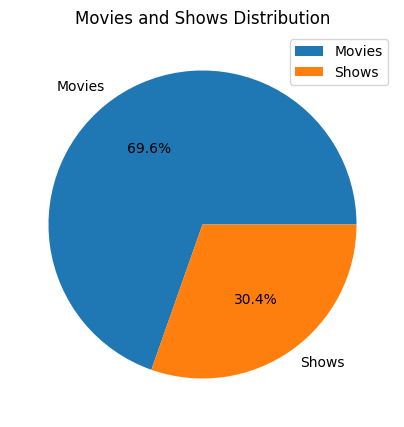

In [14]:
# Create pie chart to show distribution of movies and shows.
plot = type_counts_df.plot.pie(y='count', figsize=(5, 5), labels=['Movies', 'Shows'], autopct='%1.1f%%')

# Set figure title
plt.title('Movies and Shows Distribution')

# Set y-axis label
plt.ylabel('')

In [15]:
# Create dataframe to include Show ID, Title, Type, and all genres related to movie/show.
# Dataframe 1 includes show id, title, and type
df1 = simple_data[["show_id", "title", "type"]]

# Dataframe 2 will parse the data in the listed_in column
df2 = simple_data["listed_in"].str.split(pat = ",", expand=True)

# Put df1 and df2 together into 1 dataframe
genre_data = pd.concat([df1, df2], axis=1, ignore_index=False)

# Rename columns in new dataframe
genre_data = genre_data.rename({'show_id':'Show ID', 'title': 'Title', 'Type':'Type', 0:'Genre 1', 1:'Genre 2',2:'Genre 3'}, axis=1)

#display(genre_data)

In [16]:
# Get total number of movies/shows in each genre.
# Get count in genre 1 column
counts1 = genre_data['Genre 1'].value_counts()

# Get count in genre 2 column
counts2 = genre_data['Genre 2'].value_counts()

# Get count in genre 3 column
counts3 = genre_data['Genre 3'].value_counts()

# Get sum of counts1 and counts2
counts4 = counts1.add(counts2, fill_value=0)

# Get sum of all counts
genre_count = counts4.add(counts4, fill_value=0)

# Convert 'count' series to dataframe
genre_count = genre_count.to_frame('count').reset_index()

# Convert numbers in count column from float to int
genre_count['count'] = genre_count['count'].astype(int)

# Sort genres by total number of movies/shows starting with greatest number.
genre_count = genre_count.sort_values(by=['count'], ascending=False)

# Rename columns
genre_count = genre_count.rename({'index':'Genre', 'count': 'Count'}, axis=1)

#display(genre_count)

Text(0, 0.5, 'Count')

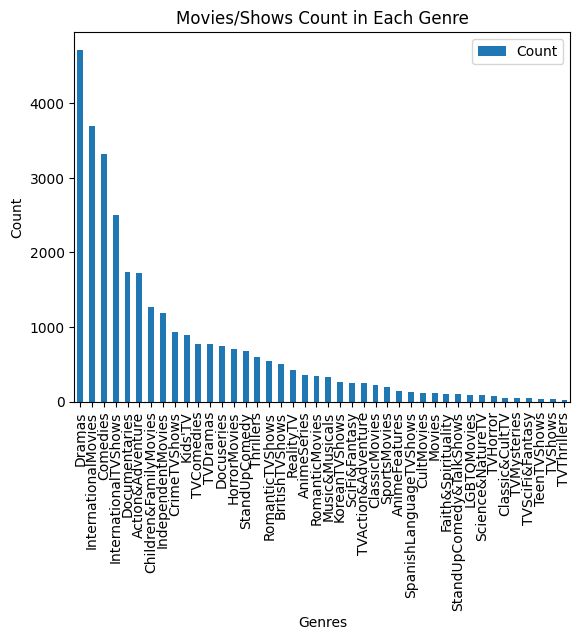

In [17]:
# Create bar graph of distribution of shows and movies into genres
# Rotate x-axis tick labels 90 degrees
ax = genre_count.plot.bar('Genre', 'Count',rot=90)

# Set title of figure
plt.title('Movies/Shows Count in Each Genre')

# Set x-axis label
plt.xlabel('Genres')

# Set y-axis label
plt.ylabel('Count')

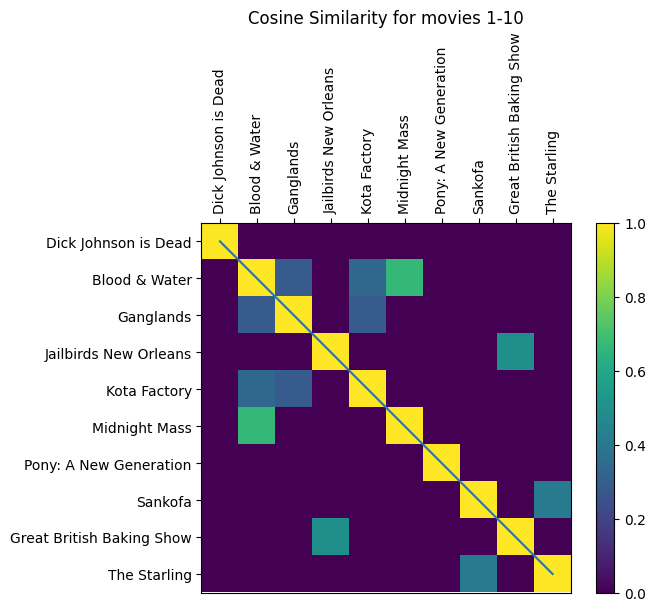

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Creating sample cosine similarity matrix
# Using movies 1-10 to show a sample of a cosine similarity matrix.
g = simple_data['listed_in'].iloc[0:10].tolist()

# Vectorize data using CountVectorizer
CV = CountVectorizer()
g_matrix = CV.fit_transform(g)

# After data is vectorized, cosine similarity can be used to provide similarity scores between movies/shows.
similarity = cosine_similarity(g_matrix)

x = ['Dick Johnson is Dead', 'Blood & Water', 'Ganglands', 'Jailbirds New Orleans', 'Kota Factory', 'Midnight Mass', 'Pony: A New Generation', 
     'Sankofa', 'Great British Baking Show' ,'The Starling']
y = ['Dick Johnson is Dead', 'Blood & Water', 'Ganglands', 'Jailbirds New Orleans', 'Kota Factory', 'Midnight Mass', 'Pony: A New Generation', 
     'Sankofa', 'Great British Baking Show' ,'The Starling']

# Create showing consine similarity
plt.title('Cosine Similarity for movies 1-10')
plt.imshow(similarity)

plt.colorbar()
plt.plot(x,y)
ax = plt.gca()

# Move x-axis tick labels to top
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# Rotate x-axis labels 90 degrees
ax.xaxis.set_tick_params(rotation=90)

In [19]:
# Will be using all movies/shows in the dataset to look for movie/show recommendations.
genre = simple_data['listed_in'].tolist()

# Vectorize data using CountVectorizer
CV = CountVectorizer()

# Transform data into matrix
genre_matrix = CV.fit_transform(genre)

# After data is vectorized, cosine similarity can be used to provide similarity scores between movies/shows.
similarity_genre = cosine_similarity(genre_matrix)
indices_genre = pd.Series(all_data.index,index=all_data['title']).drop_duplicates()

In [20]:
# Function to recommend move/show.
def recommendations_by_genre(title):
    title = title.lower()
    similarity_genre == similarity_genre
    print("Recommendations based on genre related to: " + title)
    index = indices_genre[title]
    similarity_score = list(enumerate(similarity_genre[index]))
    similarity_score = sorted(similarity_score, key=lambda x:x[1], reverse=True)
    sim_score = similarity_score[1:20]
    movie_indice = [i[0] for i in sim_score]
    display(sim_score)
    # Dataframe with show/movie title and genre. 
    this_title = simple_data[['title', 'listed_in']].loc[movie_indice]

    # Rename columns
    this_title = this_title.rename({'title':'Title', 'listed_in': 'Genres'}, axis=1)
    return this_title

In [21]:
#display(recommendations_by_genre("Midnight Mass"))

In [22]:
import tkinter as tk
from tkinter import *
from tkinter import ttk 

In [23]:
# Create GUI
# Create window
window = Tk()

# Size of the window (width x height)
window.geometry("1500x1000")

# Title of the window
window.title("Netflix Recommendations System")

# Search button function
def recc():
    movie_text = str(search_bar.get(1.0, "end-1c"))
    recs = recommendations_by_genre(movie_text)
    recommendations.config(text = recs['Title'].iloc[1:20])
    return recs

# Create label above search bar
header = Label(text = "Search movie or show to see recommendations",font=('Arial', 20))

# Show label above search bar
header.pack()

# Create search bar
search_bar = Text(window,
                  height = 3,
                  width = 50,
                  font=('Arial', 25))
# Display search bar.
search_bar.pack()

# Create search button
search_btn = Button(window, height = 2,
                 width = 100, 
                 text ="Show List of Recommended Movies/Shows",
                 command = recc)

# Display search button.
search_btn.pack()

recommendations = Label(window)

recommendations.pack()

# Open window
window.mainloop()